# Домашнее задание "Однофакторный дисперсионный анализ (ANOVA)"

**Инструкции:**
- Скачайте этот файл и заполните ячейки с кодом и текстовыми выводами.
- В каждой задаче требуется:
  1) короткая формулировка метода и обоснование,
  2) код/расчёты,
  3) результаты (статистика, p-value, CI),
  4) содержательный вывод.
- Используйте `scipy`, `statsmodels`, `pingouin` или `scikit-posthocs` по желанию. При нарушении допущений объясните, какие альтернативы применили.

Формат сдачи: `.ipynb` с заполненными ячейками и выводами.

In [122]:
# дополняйте ячейку любыми импортами по желанию!
import numpy as np
import pandas as pd
import scipy.stats as st

### Задание 1. Сопоставление статистик

Вам предложены описания ситуаций и статистических процедур. Для каждой ситуации укажите наилучшую применимую статистику из списка: `z-test`, `t-test`, `Welch t-test`, `F-test` (сравнение дисперсий), `χ^2` (goodness-of-fit), `ANOVA (one-way)`, `Tukey HSD`, `Levene`.

Ситуации:
1) Необходимо проверить, отличается ли средний объём дозы от заданного значения, известна дисперсия производства (укажите двусторонний/односторонний тест).
2) Сравнить средние двух независимых групп при неизвестных, но равных дисперсиях.
3) Сравнить средние двух независимых групп при неизвестных и неравных дисперсиях.
4) Оценить, одинаковы ли средние в трёх и более группах.
5) Проверить, согласуются ли наблюдаемые частоты с распределением Пуассона.

**Требуется:** кратко объясните выбор для каждой ситуации (1—2 предложения).


### Ответ:

Для пунктов 1-4 общим первым шагом является проверка данных на нормальность и оценка объема выборки.
Если данные далеки от нормальных и выборка мала, применяем непараметрические методы/бутстреп-методы.
Если данные отличаются от нормального распределения, но выборка достаточно большая, опираемся на ЦПТ и используем подход как для нормального распределения.

Ниже для 1-4 пунктов будут указаны применяемые статистики для случая нормального распределения

1. Т.к. дисперсия известна, выбираем z-test. Используем двусторонний тест, поскольку в задаче требуется проверить отличие среднего объема дозы без указания, в большую или меньшую сторону.

2. Используем t-тест (т.к. данный метод для двух независимых групп используется при неизвестных, но равных дисперсиях)

3. Выбираем Welch t-test, т.к. он не требует равенства дисперсий

4. ANOVA (one-way), предварительно проверив равенство/приблизительное равенство дисперсий Levene-тестом. Если равенство дисперсий не соблюдается, то можно использовать, например, Welch ANOVA. Далее, если равенство соблюдается, можно выполнить пост-hoc анализ Tukey HSD.

5. x^2 (goodness-of-fit). Выбор обусловлен тем, что критерий хи-квадрат применяется для проверки соответствия эмпирического распределения теоретическому 

### Задание 2. Тест для дозатора (z-test, двусторонний)

Инженерная задача. Дозатор рассчитывает среднюю дозу 3.00 г. Получено $n=50$ измерений со средним $\overline X=3.005$ и известным стандартным отклонением процесса $\sigma=0.015$.

а) Проведите двусторонний z-тест для проверки $H_0:\,\mu=3.00$ при $\alpha=0.05$.

б) Постройте 95% доверительный интервал для $\mu$.

в) Сделайте практический вывод для инженера: нужно ли перенастраивать дозатор?

**Требуется:** формулы расчёта, численные значения (z_obs, p-value, CI), вывод.


In [5]:
mu0 = 3.00
xbar = 3.005
sigma = 0.015
n = 50

# Решение
from scipy.stats import norm, t
alpha = 0.05
# считаем наблюдаемую z-статистику:
z_obs = (xbar - mu0) / (sigma / np.sqrt(n)) 

#p-value (2-сторонний тест):
p_value = 2 * (1 - norm.cdf(abs(z_obs)))

# Критическое значение в нашем случае:
z_critical = norm.ppf(1-alpha/2)
#Доверительный интервал:

ci = (round(xbar - z_critical * sigma/np.sqrt(n), 4), round(xbar + z_critical * sigma/np.sqrt(n), 4))
print(f'Наблюдаемая z-статистика: {z_obs:.4f}')
print(f'p-value: {p_value:.4f}')
print(f'Доверительный интервал для mu: {ci}')


Наблюдаемая z-статистика: 2.3570
p-value: 0.0184
Доверительный интервал для mu: (np.float64(3.0008), np.float64(3.0092))


Вывод: 
1. Проверяемое значение (m0 = 3.00 г) не вошло в доверительный интервал. Нижняя граница CI выше 3.00 г. Т.е. статистически значимо завышение отмеряемой дозы. 
P-value мнее 0,05 - гипотезу H0 отвергаем.
2. Тем не менее, практическая значимость зависит от технологии и требований производства. Отклонения внутри доверительного интервала от 3.00 г небольшие (0.0008-0.0092 г.). Если технология допускает такое отклонение, то перенастройка не требуется. В противном случае следует устранить завышение отмеряемой дозы


### Задание 3. Сравнение прочности материалов (t-test vs Welch)

Даны две независимые выборки прочности материалов (в MPa):

| Группа    | Наблюдения                                                                                                |
| :-------- | :-------------------------------------------------------------------------------------------------------- |
| A (n₁=15) | [51.99, 49.45, 52.59, 56.09, 49.06, 49.06, 56.32, 53.07, 48.12, 52.17, 48.15, 48.14, 50.97, 42.35, 43.10] |
| B (n₂=10) | [48.63, 45.92, 53.89, 46.55, 43.53, 60.79, 50.65, 52.41, 43.45, 48.73]                                    |

**Требуется:**

1. Проверить равенство дисперсий с помощью тестов **Levene** и классического **F-test**.
2. В зависимости от результата выполнить либо **pooled t-test**, либо **Welch t-test** для проверки
   $H_0:$ $\mu_A = \mu_B$ при $\alpha = 0.05$.
3. Построить 95% доверительный интервал для разности средних и интерпретировать.
4. Оформить заключение и вывод.


In [34]:
A = np.array([51.99,49.45,52.59,56.09,49.06,49.06,56.32,53.07,48.12,52.17,48.15,48.14,50.97,42.35,43.10])
B = np.array([48.63,45.92,53.89,46.55,43.53,60.79,50.65,52.41,43.45,48.73])

# Ваш код и расчёты

from scipy.stats import levene
from scipy.stats import f


# 1. Проверим равенство диспрерсий
# 1.1. Тест Levene
stat_levene, p_levene = levene(A, B)
print('Пункт 1. Проверяем равенство дисперсий\n')
print(f"P-value_Levene: {p_levene:.4f}")

# 1. 2. Классический F-тест
var_A = np.var(A, ddof=1)  # используем несмещённую дисперсия
var_B = np.var(B, ddof=1)

F_stat = var_A / var_B if var_A >= var_B else var_B / var_A
df1 = len(A) - 1
df2 = len(B) - 1

p_F = 2 * min(f.cdf(F_stat, df1, df2), 1 - f.cdf(F_stat, df1, df2))

print(f"Дисперсия A: {var_A:.4f}")
print(f"Дисперсия B: {var_B:.4f}")
print(f"F-статистика: {F_stat:.4f}")
print(f"F-тест_P-value: {p_F:.4f}")


# 2. Реализуем Welch-тест (см. обоснование в выводах)

def welch_t_test(sample1, sample2, alpha=0.05):
   
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    
    se = np.sqrt(var1/n1 + var2/n2)
    
    # t-статистика
    t_stat = (mean1 - mean2) / se
    
    # Степени свободы
    df = (var1/n1 + var2/n2)**2 / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))
    
    # P-value
    p_value = 2 * (1 - t.cdf(abs(t_stat), df))
    
    # Критическое значение t
    t_crit = t.ppf(1 - alpha/2, df)
    
    # Доверительный интервал
    ci_lower = (mean1 - mean2) - t_crit * se
    ci_upper = (mean1 - mean2) + t_crit * se
    
    return {
        't_statistic': t_stat,
        'p_value': p_value,
        'df': df,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'mean_diff': mean1 - mean2,
        'se': se
    }


# 3. Выполним Welch-тест:

result = welch_t_test(A, B, alpha=0.05)

print("\nПункт 2-3 Welch t-test \n")
print(f"t-статистика: {result['t_statistic']:.4f}")
print(f"P-value: {result['p_value']:.4f}")
print(f"Разность средних (A - B): {result['mean_diff']:.4f}")
print(f"95% доверительный интервал: [{result['ci_lower']:.4f}, {result['ci_upper']:.4f}]")

# Проверка гипотезы
if result['p_value'] < 0.05:
    print("\nВывод: Отвергаем H₀ - средние различаются (p < 0.05)")
else:
    print("\nВывод: Не отвергаем H₀ - средние не различаются (p > 0.05)")


Пункт 1. Проверяем равенство дисперсий

P-value_Levene: 0.5009
Дисперсия A: 15.8118
Дисперсия B: 27.9576
F-статистика: 1.7681
F-тест_P-value: 0.3928

Пункт 2-3 Welch t-test 

t-статистика: 0.2992
P-value: 0.7688
Разность средних (A - B): 0.5870
95% доверительный интервал: [-3.5804, 4.7544]

Вывод: Не отвергаем H₀ - средние не различаются (p > 0.05)


1. Проверка равенства дисперсий.
Выборочные дисперсии отличаются (дисперсия группы B выше в 1,77 раз, чем дисперсия группы А).
Однако отвергнуть гипотезу о равенстве дисперсий мы не можем, т.к. p-value существенно выше 0,05 в обоих тестах. Т.е. это различие может быть случайным из-за небольшого объема выборок.

2. Несмотря на то, что отвергнуть гипотезу о равенстве дисперсий мы не можем, дисперсии выборок численно отличаются (хотя и статистически значимых различий не обнаружено). Полагаю, более надежным будет использование Welch-теста, т.к. он не требует равенства дисперсий и более устойчив.

3. Между двумя выборками наблюдается разность средних, равная примерно 0.59. При этом в доверительный интервал входит 0. Т.е. истинная разность средних может быть нулевой. 
p-value выше 0,05 (т.е. статистически значимого различия нет). Вывод - нет оснований отвергать нулевую гипотезу о сходстве средних двух выборок. Наблюдаемая разность 0.59 может быть случайным отклонением

4. Общий вывод: материалы А и Б демонстрируют статистически неразличимую прочность. Однако для ответственных производств, где критична точность, меньшая, чем CI (например, +-1.0), рекомендуется продолжить мониторинг (увеличить объем выборки и повторно исследовать различие)


### Задание 4. Парные измерения — новая vs старая схема

Эксперимент парного дизайна: каждому прибору (или образцу) до и после изменения схемы измеряется показатель.

Даны пары (старое, новое):

$(12.5, 12.2), (13.1,13.0), (11.8,12.0), (12.9,12.7), (13.5,13.6), (12.0,11.9), (13.2,13.4)$

а) Проверьте нормальность распределения разностей (Shapiro-Wilk).

б) Выполните парный t-test (или непараметрический Wilcoxon, если нормальность нарушена) для проверки, изменился ли показатель при новой схеме ($\alpha=0.05$).

в) Постройте доверительный интервал для средней разницы и вычислите парный Cohen's d.

**Требуется:** расчёты, тест, p-value, CI, эффект и вывод.

In [17]:
old = np.array([12.5,13.1,11.8,12.9,13.5,12.0,13.2])
new = np.array([12.2,13.0,12.0,12.7,13.6,11.9,13.4])

# 1. Проверим нормальность распределения разностей

from scipy.stats import shapiro

# 1.1. Вычислим разности
diffs = old - new

# 1.2. Проведем тест Shapiro-Wilk
stat, p_value = shapiro(diffs)

print(f"1. Тест Shapiro-Wilk:\n")
print(f"Статистика W = {stat:.4f}")
print(f"P-value = {p_value:.4f}")

# 2. Проведем парный t-test для проверки изменения показателя

from scipy.stats import ttest_rel, t
t_stat, p_value = ttest_rel(old, new)


std_diff = np.std(diffs, ddof=1)
n = len(diffs)
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, n-1)  


print("\n2. Парный t-тест для проверки изменения показателя \n")
print(f"t_critical: {t_critical}")
print(f"t-статистика: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 3. Построим доверительный интервал для средней разницы и вычислим парный Cohen's d
# 3.1. Доверительный интервал для средней разницы:

mean_diff = np.mean(diffs) 
ci_lower = mean_diff - t_critical * (std_diff / np.sqrt(n))
ci_upper = mean_diff + t_critical * (std_diff / np.sqrt(n))

print(f"\n3. Доверительный интервал для средней разницы и вычисление парного Cohen's d:\n")

print(f"Средняя разность: {mean_diff:.4f}")
print(f"95% ДИ для разности средних: [{ci_lower:.4f}, {ci_upper:.4f}]")

# 3.2. парный Cohen's d:
d = mean_diff / std_diff
print(f"Парный Cohen's d: {d:.4f}")

1. Тест Shapiro-Wilk:

Статистика W = 0.9071
P-value = 0.3758

2. Парный t-тест для проверки изменения показателя 

t_critical: 2.4469118511449692
t-статистика: 0.3825
P-value: 0.7152

3. Доверительный интервал для средней разницы и вычисление парного Cohen's d:

Средняя разность: 0.0286
95% ДИ для разности средних: [-0.1542, 0.2113]
Парный Cohen's d: 0.1446


Выводы и рассуждения:

1. Тест Shapiro-Wilk не выявил отклонений от нормальности распределения разностей:
   - статистика W ближе к 1 (чем ближе к 1, тем ближе распределение к нормальному)
   - p-value более 0,05 (т.е. нет оснований отвергать гипотезу о нормальности)
   Следовательно, далее в задаче можем применять методы, подходящие для нормального распределения (парный т-тест в нашем случае).
   Однако есть нюанс: у нас очень малочисленная выборка (n =7), что может давать искажения. Тем не менее, в задаче не требуется применение доп. методов анализа данных на нормальность, поэтому останавливаемся на текущем выводе. В реальных (рабочих) ситуациях либо использовали более расширенную выборку (при возможности), либо доп. методы оценки нормальности.

2. Проведенный тест не показал статистически значимых различий показателя после изменения схемы:
   - t-статистика существенно ниже критического значения
   - p-value более 0,05
   - в доверительный интервал входит значение 0 (т.е. истинная разница может быть равной нулю) 
   - парный Cohen's d отражает очень небольшой эффект - разность всего ок. 14,5% стандартного отклнения.
   
   Средняя разность составила всего 0,029 единиц (менее 1% от исходного среднего значения). Скорее всего, это изменение имеет низкую практическую значимость. Однако следует учитывать условия реального производства. Если требуется очень высокая точность, необходимо задать в тесте более жесткие ограничения (снизив aльфа до 0.01, например) и/или увеличить объем выборки.

### Задание 5. До/после — медицинский пример (paired)

Клиническое исследование: измерен уровень глюкозы у 10 пациентов **до** и **после** приёма нового лекарства.

| Пациент | До (ммоль/л) | После (ммоль/л) |
| :------ | :----------: | :-------------: |
| 1       |      7.1     |       6.6       |
| 2       |      6.8     |       6.4       |
| 3       |      7.5     |       7.1       |
| 4       |      6.9     |       6.5       |
| 5       |      7.3     |       7.2       |
| 6       |      6.5     |       6.3       |
| 7       |      7.0     |       6.6       |
| 8       |      6.7     |       6.4       |
| 9       |      7.2     |       7.0       |
| 10      |      6.9     |       6.4       |


**Требуется:**

а) Проверить нормальность распределения разностей (тест **Shapiro–Wilk**).

б) Если нормальность не отвергается — выполнить **парный t-test** при $\alpha = 0.01$.

в) Если нормальность нарушена — выполнить непараметрический тест **Wilcoxon signed-rank** и сравнить выводы.

**Формат вывода:**
Код, p-values, выводы тестов, практическая интерпретация (снижается ли уровень глюкозы достоверно?).

In [31]:
before = np.array([7.1,6.8,7.5,6.9,7.3,6.5,7.0,6.7,7.2,6.9])
after  = np.array([6.6,6.4,7.1,6.5,7.2,6.3,6.6,6.4,7.0,6.4])

# 1. Проверим нормальность распределения разностей

# 1.1. Вычислим разности
diffs = before - after

# 1.2. Проведем тест Shapiro-Wilk
stat, p_value = shapiro(diffs)

print(f"1. Тест Shapiro-Wilk:\n")
print(f"Статистика W = {stat:.4f}")
print(f"P-value = {p_value:.4f}")

if p_value > alpha:
    print(f"\nРаспределение разностей нормальоно (p > {0.05})")
else:
    print(f"\nРаспределение разностей НЕ нормально (p ≤ {0.05})")

# 2. Проведем парный t-test для проверки изменения показателя

t_stat, p_value = ttest_rel(before, after)

std_diff = np.std(diffs, ddof=1)
n = len(diffs)
alpha = 0.01
t_critical = t.ppf(1 - alpha/2, n-1)  

print("\n2. Парный t-тест для проверки изменения показателя \n")
print(f"t_critical: {t_critical:.4f}")
print(f"t-статистика: {t_stat:.4f}")
print(f"P-value: {p_value:.7f}")

if p_value < alpha:
    print(f"Выявлены статистически значимые изменения в уровне глюкозы")
else:
    print(f"Статистически значимые изменения в уровне глюкозы не выявлены")



# Дополнительно построим доверительный интервал для средней разницы:

mean_diff = np.mean(diffs) 
ci_lower = mean_diff - t_critical * (std_diff / np.sqrt(n))
ci_upper = mean_diff + t_critical * (std_diff / np.sqrt(n))

print(f"\nДоверительный интервал для средней разницы:\n")

print(f"Средняя разность: {mean_diff:.4f}")
print(f"99% ДИ для разности средних: [{ci_lower:.4f}, {ci_upper:.4f}]")

1. Тест Shapiro-Wilk:

Статистика W = 0.8960
P-value = 0.1977

Распределение разностей нормальоно (p > 0.05)

2. Парный t-тест для проверки изменения показателя 

t_critical: 3.2498
t-статистика: 7.9649
P-value: 0.0000229
Выявлены статистически значимые изменения в уровне глюкозы

Доверительный интервал для средней разницы:

Средняя разность: 0.3400
99% ДИ для разности средних: [0.2013, 0.4787]


Выводы и рассуждения:

1. Тест Shapiro-Wilk не выявил отклонений от нормальности распределения разностей:
   - статистика W ближе к 1, но несколько отличается от 1, что может указывать на умеренное отклонение от идеальной нормальности. Однако практически редко можно видеть идеальную нормальность. При W ок. 0,9 не отвергаем гипотезу о нормальности.
   - p-value более 0,05 (т.е. нет оснований отвергать гипотезу о нормальности)
   Следовательно, далее в задаче можем применять методы, подходящие для нормального распределения
   Однако есть нюанс: у нас очень малочисленная выборка (n =10), что может давать искажения. Тем не менее, в задаче не требуется применение доп. методов анализа данных на нормальность, поэтому останавливаемся на текущем выводе. В реальных (рабочих) ситуациях либо использовали более расширенную выборку (при возможности), либо доп. методы оценки нормальности.

2. Т.к. не было выявлено отклонений от нормальности, провели парный t-тест. Дополнительно построили доверительный интервал для средней разницы. Результат: отвергаем нулевую гипотезу об отсутствии изменений в уровне глюкозы, принимаем гипотезу H1 о наличии статистически значимых изменений. Обоснование:
   - t-статистика выше критического значения (7.96 > 3.25)
   - p-value сущственно меньше 0,01 (0.00002 < 0.01)
   - в 99% доверительный интервал не входит 0 (т.е. отсутствие разницы маловероятно)

Таким образом, делаем вывод о достоверном снижении глюкозы   

### Задание 6. Welch и Games-Howell (симуляция с неравными дисперсиями)

Смоделируйте три группы с одинаковыми средними (например, 10), но существенно разными дисперсиями и неравными размерами выборок (пример: $n_1=20, n_2=8, n_3=5$).

а) Покажите, что классическая ANOVA может ошибочно интерпретировать разницу, если нарушена гомоскедастичность.

б) Выполните Welch ANOVA и пост-hoc Games-Howell.

в) Сравните результаты и сделайте вывод о корректности подходов.

**Требуется:** код симуляции, результаты ANOVA и Welch, таблица post-hoc и вывод.


In [67]:
# Смоделируем 3 группы (нормально распределенных) в соответствии с условиями задачи:
np.random.seed(43)

group1 = np.random.normal(loc=10, scale=2, size=30)
group2 = np.random.normal(loc=10, scale=5, size=8)
group3 = np.random.normal(loc=10, scale=10, size=5)

# Проведем тест Levene, чтобы убедиться в различии дисперсий
_, p_levene = levene(group1, group2, group3)

print(f"\nТест Левена: p = {p_levene:.5f} {'дисперсии разные' if p_levene < 0.05 else 'дисперсии равны'}\n")

#1. Покажем ошибочную инетрпретацию разницу классической ANOVA при нарушении равенства дисперсий

from scipy.stats import f_oneway
f_stat, p_anova = f_oneway(group1, group2, group3)
print(f'1. Классическая Anova:\n')
print(f'F = {f_stat:.3f}, p = {p_anova:.4f}')
print(f"Результат классической ANOVA: {'Средние различаются' if p_anova < 0.05 else 'Средние не различаются'} (alfa=0.05)")

# 2. Выполним Welch-Anova и пост-hoc Games-Howell

# 2.1. Welch-Anova
df = pd.DataFrame({
    'value': np.concatenate([group1, group2, group3]),
    'group': ['group1']*30 + ['group2']*8 + ['group3']*5
})
from pingouin import welch_anova, pairwise_gameshowell

welch_result = welch_anova(data=df, dv='value', between='group')
print('\n2. Welch-ANOVA и пост-hoc Games-Howell:')
print('\n2.1. Результаты Welch-ANOVA:')
print(f'\n{welch_result.round(4)}')

alpha = 0.05
if welch_result['p-unc'].values[0] < alpha:
    print(f"\nИнтерпретация Welch ANOVA: Средние значимо различаются (p < {alpha})")
else:
    print(f"\nИнтерпретация Welch ANOVA: Отсутствие стат. значимых различий в средних (p ≥ {alpha})")

# 2.2. пост-hoc Games-Howell

posthoc = pairwise_gameshowell(data=df, dv='value', between='group')
print('\n2.2. пост-hoc Games-Howell:\n')
print(posthoc.round(4))

print("\nИнтерпретация Games-Howell")
for i, row in posthoc.iterrows():
    pair = row['A'] + " vs " + row['B']
    pval = row['pval']
    
    if pval < 0.05:
        print(f"{pair:10}: p = {pval:.4f} < 0.05 - значимое различие")
    else:
        print(f"{pair:10}: p = {pval:.4f} ≥ 0.05 - различие не значимо")


Тест Левена: p = 0.00163 дисперсии разные

1. Классическая Anova:

F = 7.461, p = 0.0018
Результат классической ANOVA: Средние различаются (alfa=0.05)

2. Welch-ANOVA и пост-hoc Games-Howell:

2.1. Результаты Welch-ANOVA:

  Source  ddof1   ddof2       F   p-unc     np2
0  group      2  6.9615  1.7712  0.2389  0.2717

Интерпретация Welch ANOVA: Отсутствие стат. значимых различий в средних (p ≥ 0.05)

2.2. пост-hoc Games-Howell:

        A       B  mean(A)  mean(B)    diff      se       T      df    pval  \
0  group1  group2  10.2562  10.0459  0.2102  2.3142  0.0908  7.3104  0.9955   
1  group1  group3  10.2562  17.8286 -7.5725  3.8503 -1.9667  4.0629  0.2341   
2  group2  group3  10.0459  17.8286 -7.7827  4.4665 -1.7425  6.8603  0.2574   

   hedges  
0  0.0622  
1 -2.1402  
2 -0.9905  

Интерпретация Games-Howell
group1 vs group2: p = 0.9955 ≥ 0.05 - различие не значимо
group1 vs group3: p = 0.2341 ≥ 0.05 - различие не значимо
group2 vs group3: p = 0.2574 ≥ 0.05 - различие не значимо

1. Сгенерировали 3 выборки согласно условию задачи. Тест Levene подтвердил различие дисперсий. F-статистика также показывает существенное различие дисперсий.

  Классическая ANOVA ошибочно показала различие средних (p<0.05) при отсутствии различий. Это произошло, т.к. Anova приняла случайное отклонение в маленькой выборке с большой дисперсией за реальный эффект.

2. Согласно результату Welch-ANOVA, нет оснований отвергать нулевую гипотезу о равенстве средних значений (p-value >0.05), несмотря на то, что есть наблюдаемые различия в выборочных средних (F = 1.7712)

3. Анализ результатов пост-hoc Games-Howell также подтверждает отсутствие статистически значимых различий в средних между группами. При этом между группами 1 и 3 и 2 и 3 наблюдается высокая выборочная разница в средних (7.6-7.7 vs ок. 10-10.3), однако эта разница не является статистически значимой (p-value более 0,05)

Таким образом, можно сделать общий вывод: при отсутствии гомоскедастичности Welch ANOVA учитывает возможность случайных отклонений от среднего, в то время как в классической ANOVA случайные отклонения могут привести к ошибке в интерпретации.

### Задание 7. ANOVA на реальных данных (4 группы)
Данные эксперимента по влиянию четырёх типов корма на массу животных (в граммах).
Каждая группа содержит по 6 наблюдений.

| Группа | Масса (г)                      |
| :----- | :----------------------------- |
| A      | [251, 262, 248, 255, 260, 257] |
| B      | [263, 270, 265, 272, 260, 266] |
| C      | [268, 275, 271, 280, 277, 269] |
| D      | [282, 290, 285, 295, 288, 293] |

**Требуется:**

а) Выполнить графическую визуализацию (boxplots и точки). Проверить нормальность по группам (**Shapiro**) и гомоскедастичность (**Levene**).

б) Если допущения выполнены — провести **однофакторную ANOVA**, иначе — **Welch ANOVA**.

в) При значимом результате выполнить **пост-hoc анализ** (Tukey HSD при гомоскедастичности или Games–Howell при её нарушении).

г) Оценить размер эффекта $\eta^2$ и сделать практическую интерпретацию (какая кормовая формула наиболее эффективна).


1. Графическая визуализация. Проверка на нормальность и гомоскедастичность
1.1. Графическая визуализация



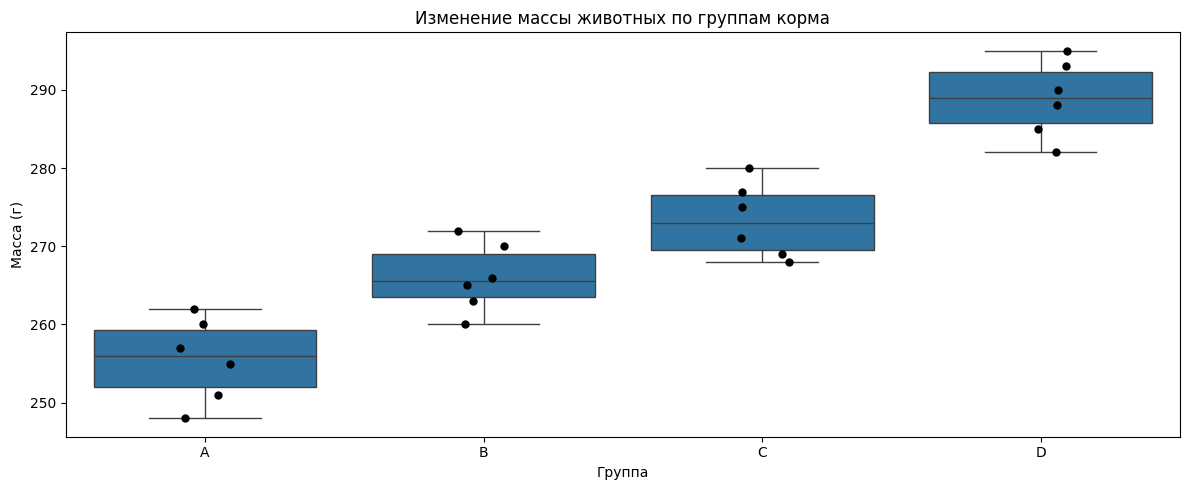


1.2.1. Проверка нормальности

Группа A: W=0.9682, p=0.8799 (нормальна)
Группа B: W=0.9738, p=0.9168 (нормальна)
Группа C: W=0.9387, p=0.6488 (нормальна)
Группа D: W=0.9781, p=0.9415 (нормальна)

1.2.2. Проверка гомоскедастичности

Статистика: 0.1291
p-значение: 0.9417
Гомогенность дисперсий: принимается

2. Классическая Anova:

F = 49.925, p = 0.0000000018
Результат классической ANOVA: Средние различаются (alfa=0.05)

3. Пост-hoc анализ: Tukey HSD

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     A      B     10.5 0.0064  2.6524 18.3476   True
     A      C  17.8333    0.0  9.9858 25.6809   True
     A      D  33.3333    0.0 25.4858 41.1809   True
     B      C   7.3333 0.0723 -0.5142 15.1809  False
     B      D  22.8333    0.0 14.9858 30.6809   True
     C      D     15.5 0.0001  7.6524 23.3476   True
----------------------------------------------------

Расчет эффекта 

In [108]:
A = [251,262,248,255,260,257]
B = [263,270,265,272,260,266]
C = [268,275,271,280,277,269]
D = [282,290,285,295,288,293]

# 1. Выполним графическую визаулизацию. Проверим нормальность и гомоскедастичность
# 1.1. Графическая визуализация

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({
    'Группа': ['A']*len(A) + ['B']*len(B) + ['C']*len(C) + ['D']*len(D),
    'Масса': A + B + C + D
})

fig, ax = plt.subplots(figsize=(12, 5))
print ('1. Графическая визуализация. Проверка на нормальность и гомоскедастичность')
print ('1.1. Графическая визуализация\n')

# Boxplots и точки
sns.boxplot(data=df, x='Группа', y='Масса', ax=ax)
sns.stripplot(data=df, x='Группа', y='Масса', color='black', size=6, ax=ax)
ax.set_title('Изменение массы животных по группам корма')
ax.set_ylabel('Масса (г)')

plt.tight_layout()
plt.show()

# 1.2. Проверим нормальность и гомоскедастичность
# 1.2.1. Проверим нормальность (Shapiro-Wilk):
print ('\n1.2.1. Проверка нормальности\n')

for group in ['A', 'B', 'C', 'D']:
    group_values = df[df['Группа'] == group]['Масса'].values
    stat, p = st.shapiro(group_values)
    print(f"Группа {group}: W={stat:.4f}, p={p:.4f} {'(нормальна)' if p > 0.05 else '**(не нормальна)**'}")

# 1.2.2. Проверим гомоскедастичность (Levene):
levene_stat, levene_p = st.levene(A, B, C, D)
print ('\n1.2.2. Проверка гомоскедастичности\n')
print(f"Статистика: {levene_stat:.4f}")
print(f"p-значение: {levene_p:.4f}")
print(f"Гомогенность дисперсий: {'принимается' if levene_p > 0.05 else '**отвергается**'}")

# 2. Поскольку допущения выполнены, проведем классическую ANOVA
f_stat, p_anova = f_oneway(A, B, C, D)
print(f'\n2. Классическая Anova:\n')
print(f'F = {f_stat:.3f}, p = {p_anova:.10f}')
print(f"Результат классической ANOVA: {'Средние различаются' if p_anova < 0.05 else 'Средние не различаются'} (alfa=0.05)")

# 3. Выполним пост-hoc анализ (Tukey HSD)

from statsmodels.stats.multicomp import pairwise_tukeyhsd

all_data = A + B + C + D
groups = ['A']*len(A) + ['B']*len(B) + ['C']*len(C) + ['D']*len(D)
print("\n3. Пост-hoc анализ: Tukey HSD\n")

tukey_result = pairwise_tukeyhsd(all_data, groups, alpha=0.05)
print(tukey_result)

# 4. Рассчитаем эффект η² через F-статистику

k = 4  
N = len(all_data) 
eta_squared_f = (f_stat * (k - 1)) / (f_stat * (k - 1) + (N - k))

print('\nРасчет эффекта η²')
print(f"η²F: ({f_stat:.3f} × {k-1}) / ({f_stat:.3f} × {k-1} + {N-k}) = {eta_squared_f:.4f}")

print(f"η² = {eta_squared_f:.4f} ({eta_squared_f*100:.1f}%)")

if eta_squared_f >= 0.14:
    interpretation = "Очень большой эффект"
    explanation = "Фактор (тип корма) объясняет более 14% дисперсии массы животных"
elif eta_squared_f >= 0.06:
    interpretation = "Большой эффект"
    explanation = "Фактор объясняет 6-14% дисперсии"
elif eta_squared_f >= 0.01:
    interpretation = "Средний"
    explanation = "Фактор объясняет 1-6% дисперсии"
else:
    interpretation = "Малый эффект"
    explanation = "Фактор объясняет менее 1% дисперсии"

print(f"Интерпретация: {interpretation}")
print(f"Объяснение: {explanation}")



1. Графическая визуализация. Проверка на нормальность и гомоскедастичность

   1.1. По графику можно сделать следующие вводы:
       - изменение масс животных увеличивается от группы А к группе D
       - выбросов не найдено ни в одной из групп (все точки расположены в пределах усов)
       - размах в группах существенно не отличается друг от друга
       - наблюдается некоторая асимметрия в группах А, D (нижний ус длиннее верхнего - точки смещены вверх) и в группе C (наоборот - верхний ус длиннее нижнего, точки смещены вниз)
       
   1.2. Проверка на нормальность и гомоскедастичность дала положительные результаты во всех группах (более детально, как интерпретируем тесты описывала в предыдущих заданиях)
   
2. Поскольку допущения о нормальности и гомоскедастичности выполнены, проведена классическая ANOVA.
Вывод: обнаружено статистически значимое различие в средних изменениях массы животных по исследуемым группам (p-value 0.000 <0.05). F-статистика высокая (ок. 49,9), что говорит о сильных различиях между группами.

3. Применили Tukey HSD для пост-hoc анализа, т.к. соблюдается условие гомоскедастичности.
Результат: при попарном сравнении групп наблюдается 5 стат. значимых различий из 6 (между группой B и C есть различия, но они не стат значимы).
Тест Тьюки подтвердил, что корм D приводит к наибольшей массе животных. Корма C и B дают статистически схожий результат, но оба превосходят корм A. Разница между группами B и C (7.3 г) существует, но не достигает статистической значимости при выбранном уровне α=0.05.

4. Расчет $\eta^2$ показал, что фактор корма объясняет более 88% дисперсии - это значительный эффект.

Для практической интерпретации об эффективности корма не хватает дополнительных вводных:
 - учитывается ли баланс витаминов и минералов и прочие характеристики
 - какую проблему необходимо решить - если требуется набор веса животными, то при прочих равных условиях рекомндуем выбирать корм D. Если животные страдают избыточным весом, то корм A (при соблюдении баланса полезных веществ и прочих необходимых требований)

### Задание 8. Планирование эксперимента: размер выборки и мощность

Планируется эксперимент с $l = 4$ группами. Требуется обеспечить мощность $1 - \beta = 0.8$
для обнаружения разницы $\Delta = 0.5\sigma$ между любыми парами групп
(равный размер групп $n$), при $\alpha = 0.05$.

**Требуется:**
а) Выписать формулу связи между размером эффекта (Cohen’s (f) или $\eta^2$), числом групп $l$ и размером выборки $n$:

$$
f = \sqrt{\frac{\eta^2}{1 - \eta^2}}, \quad \eta^2 = \frac{f^2}{1 + f^2}.
$$

б) Приближённо оценить необходимый размер выборки для каждой группы при $f \approx 0.25$ (средний эффект по Cohen).

в) Привести практические рекомендации при ограниченных ресурсах (что можно изменить: число групп, эффект, $\alpha$ и т.п.).

> Подсказка: можно использовать модуль `from statsmodels.stats.power import FTestAnovaPower`

In [121]:
alpha = 0.05
power = 0.8
f = 0.25
k = 4

from statsmodels.stats.power import FTestAnovaPower

ftest = FTestAnovaPower()

# Рассчитываем необходимый размер выборки на группу
n_per_group = ftest.solve_power(
    effect_size=f,
    nobs=None,      # то, что ищем
    alpha=alpha,
    power=power,
    k_groups=k
)

# Округляем вверх (т.к. размер выборки должен быть целым)
n_per_group_ceil = np.ceil(n_per_group)

# Вывод результатов
print(f'Результаты расчета n для обнаружения эффекта(f = {f}):')
print(f'Требуется n = {n_per_group_ceil:.0f} наблюдений в каждой группе')
print(f'Общий размер выборки: N = {n_per_group_ceil:.0f} × {k} = {n_per_group_ceil*k:.0f} наблюдений')

# Проверяем мощность при округленном n
power_check = ftest.power(
    effect_size=f,
    nobs=n_per_group_ceil,
    alpha=alpha,
    k_groups=k
)

print(f"\nПроверка: при n = {n_per_group_ceil:.0f} мощность = {power_check:.4f}")



Результаты расчета n для обнаружения эффекта(f = 0.25):
Требуется n = 179 наблюдений в каждой группе
Общий размер выборки: N = 179 × 4 = 716 наблюдений

Проверка: при n = 179 мощность = 0.8015


### Задание а
Для однофакторного дисперсионного анализа (ANOVA) мощность теста выражается через вероятность превышения критического значения нецентральным F-распределением:

$$
1-\beta = P\left(F' > F_{1-\alpha}(l-1,\ l(n-1)) \ \middle| \ \lambda \right)
$$

**где:**
- $P(\cdot)$ — вероятность события
- $F'$ — случайная величина с нецентральным F-распределением
- $F_{1-\alpha}(l-1, l(n-1))$ — критическое значение центрального F-распределения:
  - $1-\alpha$ — квантиль (для $\alpha=0.05$ это $F_{0.95}$)
  - $l-1$ — степени свободы в числителе (межгрупповые)
  - $l(n-1)$ — степени свободы в знаменателе (внутригрупповые)
- $\lambda$ — параметр нецентральности: $\lambda = n \cdot l \cdot f^2$


#### Для параметров нашего эксперимента:

$$
l=4, \quad \alpha=0.05, \quad 1-\beta=0.8, \quad f=0.25
$$

Формула принимает вид:

$$
P\left(F' > F_{0.95}(3,\, 4n-4) \ \middle| \ \lambda = 0.25n \right) = 0.8
$$

**Пояснение подстановки:**
- $l-1 = 4-1 = 3$ (степени свободы в числителе)
- $l(n-1) = 4(n-1) = 4n-4$ (степени свободы в знаменателе)
- $\lambda = n \cdot l \cdot f^2 = n \cdot 4 \cdot (0.25)^2 = 0.25n$



#### Интегральная форма записи:

Мощность можно выразить через плотность распределения:

$$
1-\beta = \int_{F_{crit}}^{\infty} f_{F'}(x \mid \lambda) \, dx
$$

где:
- $f_{F'}(x \mid \lambda)$ — плотность нецентрального F-распределения
- $F_{crit} = F_{1-\alpha}(l-1, l(n-1))$ — критическое значение


Эта формула позволит **рассчитать необходимый размер выборки $n$**, решая уравнение относительно $n$:

$$
\text{Найти } n: \quad P\left(F' > F_{0.95}(3,\, 4n-4) \mid \lambda = 0.25n \right) = 0.8$$ 

### Задание б

С использованием модуля power.FTestAnovaPower рассчитали необходимый объем выборки по заданным параметрам равный n = 179 на группу или N = 716 в целом

### Задание в

Практические рекомендации при ограниченных ресурсах:
1. Сократить число групп, выбрав только наиболее контрастные и/или практически значимые. Как в примере с кормами, можно из групп B и C оставить либо B, либо C
2. Скорректировать статистические параметры, например:
- снизить мощность до 0,75 (это снизит размер выборки)
- увеличить уровень значимости до 0.07-0.1 (с осторожностью применять - может привести к риску ложных выводов)
3. Увеличить размер эффекта (тем самым увеличив контраст), например с 0.25 до 0.3 - также приведет к сокращению выборки
4. Использовать комбинации пунктов 1-3

### Полезные подсказки и библиотеки
- Проверки: `scipy.stats.shapiro`, `scipy.stats.levene`, `scipy.stats.ttest_ind`, `scipy.stats.ttest_rel`, `scipy.stats.wilcoxon`.
- ANOVA: `statsmodels.formula.api` (ols + anova_lm), `pingouin.anova`, `scipy` (ограничено).
- Post-hoc: `statsmodels.stats.multicomp.pairwise_tukeyhsd`, `scikit-posthocs` для Games-Howell.
- Power analysis: `statsmodels.stats.power.FTestAnovaPower`.

Удачи! Сохраните ноутбук, перезапустите все ячейки от начала до конца и прикрепите файл как ответ.